In [4]:
import xarray as xr
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm

Aquired temp data at following link: 
https://resources.marine.copernicus.eu/product-download/GLOBAL_ANALYSIS_FORECAST_PHY_001_024


COORDINATES:
* LAT: 35.25 - 42.75
* LONG: -64.25 - 76.75

Aquired ship data from Global Fishing Watch - downloaded 2020 and 2021 data and consolidated into single CSV for both

In [5]:
DS = xr.open_dataset("selected-data-2021.nc")

In [6]:
DS

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 91, time: 154, longitude: 151)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 35.25 35.33 35.42 35.5 ... 42.58 42.67 42.75
  * time       (time) datetime64[ns] 2021-05-01T12:00:00 ... 2021-10-01T12:00:00
  * longitude  (longitude) float32 -76.75 -76.67 -76.58 ... -64.42 -64.33 -64.25
Data variables:
    vo         (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    bottomT    (time, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
Attributes: (12/25)
    title:                              daily mean fields from Global Ocean P...
    easting:                            longitude
    northing:                           latitude
    history:                            2022/05/17 00:08:04 MERCATOR OCEAN Ne...
    source:                             MERCATOR PSY4QV3R1
    institution:                        MERCATOR OCEAN
    ...                                 ...
    FROM_ORIGINAL_FILE__longitude_max:  179.91667
    FROM_ORIGINAL_FILE__latitude_min:   -80.0
    FROM_ORIGINAL_FILE__latitude_max:   90.0
    z_min:                              0.494025
    z_max:                              5727.917
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention

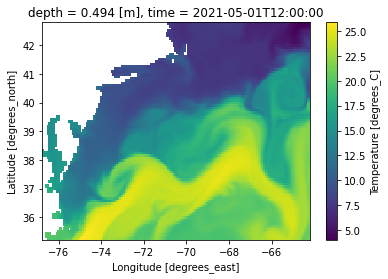

In [7]:
DS.thetao.sel(time="2021-05-01").plot()

In [8]:
import os

In [9]:
ship_location = os.listdir('ship-location-data/')

ship_location = ship_location[1:]

In [10]:
sample = pd.read_csv(f"ship-location-data/{ship_location[0]}").dropna()

In [11]:
min_lat = 35.25
max_lat = 42.75
min_long = -76.75
max_long = -64.75

In [12]:
sample = sample[sample['cell_ll_lat'] >= min_lat]
sample = sample[sample['cell_ll_lat'] <= max_lat]
sample = sample[sample['cell_ll_lon'] >= min_long]
sample = sample[sample['cell_ll_lon'] <= max_long]

In [13]:
sample

,date,cell_ll_lat,cell_ll_lon,flag,geartype,hours,fishing_hours,mmsi_present
13,2020-01-01,36.00,-75.63,USA,fishing,0.2558,0.0000,1
29,2020-01-01,42.00,-67.45,USA,fishing,0.0544,0.0000,1
69,2020-01-01,42.25,-67.52,USA,fishing,0.2947,0.0000,1
126,2020-01-01,36.50,-75.80,USA,fishing,0.2763,0.0000,1
127,2020-01-01,40.50,-70.54,USA,fishing,0.0469,0.0000,1
...,...,...,...,...,...,...,...,...
196412,2020-01-01,42.20,-67.06,CAN,trawlers,0.6525,0.6525,1
204714,2020-01-01,42.19,-66.82,CAN,trawlers,0.3505,0.3505,1
204715,2020-01-01,42.19,-66.91,CAN,trawlers,0.1777,0.1777,1
204716,2020-01-01,42.19,-66.92,CAN,trawlers,0.4302,0.4302,1


# Transforming into useful data structure

Idea: make it so that data[0][0] correlates to the same area on both data sets



## First lets fix temperature data

In [14]:
DS_ARRAY = DS.to_array().to_numpy()
# DS_ARRAY = DS_ARRAY.reshape((154, 91, 151, 6))
DS_ARRAY = np.nan_to_num(DS_ARRAY, nan=0.0)[:, :, 0, :, :]

In [15]:
DS_new = list()
for i in range(DS_ARRAY.shape[1]):
    new_var_list = list()
    for j in range(DS_ARRAY.shape[0]):
        new_var_list.append(DS_ARRAY[j, i, :, :])
    new_var_list = np.stack(new_var_list, axis=-1)
    DS_new.append(new_var_list)
DS_ARRAY = np.stack(DS_new)

In [16]:
DS_ARRAY.shape

(154, 91, 151, 6)

In [17]:
#Check that reshaping maintained data correctly
DS_sample_temp = DS.thetao.sel(time="2021-05-01").to_numpy()
DS_sample_temp = np.nan_to_num(DS_sample_temp, nan=0.0)
print((DS_sample_temp == DS_ARRAY[0, :, :, 2]).all())

True


In [18]:
with open("varaible_data.pkl", 'wb') as f:
    pickle.dump(DS_ARRAY, f)

## Now Ships

In [19]:
ship_location = os.listdir('ship-location-data/')
ship_location = ship_location[1:]

In [20]:
ship_location = [sheet for sheet in ship_location if sheet[:-4] >= '2020-05-01' and sheet[:-4] <= '2020-10-01']

In [21]:
#aggregate into one data frame
aggregate = list()
for sheet in tqdm(ship_location):
    df = pd.read_csv(f"ship-location-data/{sheet}").dropna()
    aggregate.append(df)

  0%|          | 0/154 [00:00<?, ?it/s]

In [22]:
lat_list = DS.latitude.to_numpy()
long_list = DS.longitude.to_numpy()

In [23]:
lat_dict = {lat_list[i]: i for i in range(len(lat_list))}
long_dict = {long_list[i]: i for i in range(len(long_list))}

In [24]:
####FIX ME
def coord_to_index(coord, search_list):
    min_idx = 0
    max_idx = len(search_list)
    while max_idx - 1 > min_idx:
        mid = int(np.floor((min_idx + max_idx) / 2))
        mid_val = search_list[mid]
        if coord > mid_val:
            min_idx = mid
        else:
            max_idx = mid
    return min_idx

In [25]:
grids = list()
for df in tqdm(aggregate):
    df = df[df['cell_ll_lat'] >= min_lat]
    df = df[df['cell_ll_lat'] <= max_lat]
    df = df[df['cell_ll_lon'] >= min_long]
    df = df[df['cell_ll_lon'] <= max_long]
    df['lat_idx'] = df['cell_ll_lat'].apply(lambda x: coord_to_index(x, lat_list))
    df['long_idx'] = df['cell_ll_lon'].apply(lambda x: coord_to_index(x, long_list))
    coord_mat = np.zeros((len(lat_dict), len(long_dict)))
    for idx, item in df.iterrows():
        lat_idx = item['lat_idx']
        long_idx = item['long_idx']
        coord_mat[lat_idx, long_idx] = coord_mat[lat_idx, long_idx] + 1
    grids.append(coord_mat)

  0%|          | 0/154 [00:00<?, ?it/s]

In [27]:
grids = np.stack(grids)

In [28]:
grids.shape

(154, 91, 151)

In [77]:
with open("ship_grids.pkl", 'wb') as f:
    pickle.dump(grids, f)

In [57]:
from matplotlib import pyplot as plt

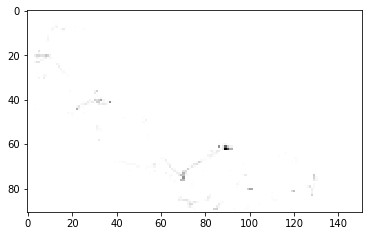

In [66]:
plt.imshow(grids[0]*30, cmap='binary', interpolation='none')

In [62]:
grids[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])